In [1]:
%pip install torch torchvision

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from PIL import Image
import matplotlib.pyplot as plt
import time

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [4]:
class InceptionSubnet(nn.Module):
    def __init__(self, embedding_size=512):
        super(InceptionSubnet, self).__init__()
        
        googlenet = models.googlenet(weights=models.GoogLeNet_Weights.DEFAULT)
        
        # Extract layers up to inception-4e
        self.inception_layers = nn.Sequential(
            googlenet.conv1,
            googlenet.maxpool1,
            googlenet.conv2,
            googlenet.conv3,
            googlenet.maxpool2,
            googlenet.inception3a,
            googlenet.inception3b,
            googlenet.maxpool3,
            googlenet.inception4a,
            googlenet.inception4b,
            googlenet.inception4c,
            googlenet.inception4d,
            googlenet.inception4e
        )
        
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        
        self.fc = nn.Linear(832, embedding_size)

    
    def forward(self, x):
        x = self.inception_layers(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.normalize(x, p=2, dim=1)
        return x

In [5]:
class Market1501Dataset(Dataset):
    
    def __init__(self, data_dir, transform=None, is_train=True):
        self.data_dir = data_dir
        self.transform = transform

        if is_train:
            self.img_dir = os.path.join(data_dir, 'bounding_box_train')
        else:
            self.img_dir = os.path.join(data_dir, 'bounding_box_test')
            
        self.img_paths = [os.path.join(self.img_dir, f) for f in os.listdir(self.img_dir) 
                           if f.endswith('.jpg') and f[0] != '-']
        
        self.labels = [int(os.path.basename(path).split('_')[0]) for path in self.img_paths]
        
        self.label_to_indices = {label: np.where(np.array(self.labels) == label)[0] 
                                 for label in np.unique(self.labels)}
        
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        label = self.labels[idx]
        
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [6]:
class DeepMetricLoss(nn.Module):
    """
    Combined global and local loss as described in the paper.
    """
    def __init__(self, margin=0.2, lambda_param=0.5):
        super(DeepMetricLoss, self).__init__()
        self.margin = margin
        self.lambda_param = lambda_param
        
    def forward(self, embeddings, labels):

        dist_mat = self._get_distance_matrix(embeddings)
        
        pos_mask, neg_mask = self._get_pair_masks(labels)
        
        local_loss = self._compute_local_loss(dist_mat, pos_mask, neg_mask)
        
        global_loss = self._compute_global_loss(dist_mat, pos_mask, neg_mask)
        
        total_loss = local_loss + self.lambda_param * global_loss
        
        return total_loss, local_loss, global_loss
    
    def _get_distance_matrix(self, embeddings):
        # ||a - b||^2 = ||a||^2 + ||b||^2 - 2(a·b) = 2 - 2(a·b) when ||a|| = ||b|| = 1
        
        dot_product = torch.matmul(embeddings, embeddings.t())
        
        dist_mat = 2.0 - 2.0 * dot_product
        
        dist_mat = torch.clamp(dist_mat, min=0.0)
        
        return dist_mat
    
    def _get_pair_masks(self, labels):
       
        labels_mat = labels.expand(len(labels), len(labels))
        labels_mat_t = labels_mat.t()
        
        pos_mask = (labels_mat == labels_mat_t).float()
        
        pos_mask = pos_mask - torch.eye(pos_mask.size(0), device=pos_mask.device)
        
        neg_mask = (labels_mat != labels_mat_t).float()
        
        return pos_mask, neg_mask
    
    def _compute_local_loss(self, dist_mat, pos_mask, neg_mask):
        # L(T) = (1/B) * sum_{(i,j)∈P} β_ij * log(1 + sum_{k} e^(d²_ij - d²_ik + α))
        
        B = torch.sum(pos_mask)
        if B == 0:
            return torch.tensor(0.0, device=dist_mat.device)
        
        pos_dist = dist_mat.unsqueeze(2)
        neg_dist = dist_mat.unsqueeze(1)
        
        triplet_diff = pos_dist - neg_dist + self.margin
        
        valid_triplets = pos_mask.unsqueeze(2) * neg_mask.unsqueeze(1)
        
        exp_triplet_diff = torch.exp(triplet_diff * valid_triplets)
        
        sum_exp = torch.sum(exp_triplet_diff, dim=2)
        
        local_loss = torch.sum(torch.log(1 + sum_exp) * pos_mask) / B
        
        return local_loss
    
    def _compute_global_loss(self, dist_mat, pos_mask, neg_mask):
    
        pos_pair_dist = dist_mat * pos_mask
        neg_pair_dist = dist_mat * neg_mask
        
        pos_pair_mean = torch.sum(pos_pair_dist) / torch.sum(pos_mask) if torch.sum(pos_mask) > 0 else torch.tensor(0.0, device=dist_mat.device)
        neg_pair_mean = torch.sum(neg_pair_dist) / torch.sum(neg_mask) if torch.sum(neg_mask) > 0 else torch.tensor(0.0, device=dist_mat.device)
        
        pos_var = torch.sum((pos_pair_dist - pos_pair_mean)**2 * pos_mask) / torch.sum(pos_mask) if torch.sum(pos_mask) > 0 else torch.tensor(0.0, device=dist_mat.device)
        neg_var = torch.sum((neg_pair_dist - neg_pair_mean)**2 * neg_mask) / torch.sum(neg_mask) if torch.sum(neg_mask) > 0 else torch.tensor(0.0, device=dist_mat.device)
        
        global_loss = pos_var + neg_var
        
        return global_loss

In [7]:
def train_model(model, train_loader, criterion, optimizer, device, num_epochs=10):

    model.train()
    
    epoch_losses = []
    epoch_local_losses = []
    epoch_global_losses = []
    batch_times = []
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        running_local_loss = 0.0
        running_global_loss = 0.0
        epoch_start_time = time.time()
        
        for batch_idx, (images, labels) in enumerate(train_loader):
            batch_start_time = time.time()
            
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            embeddings = model(images)
            
            loss, local_loss, global_loss = criterion(embeddings, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            running_local_loss += local_loss.item()
            running_global_loss += global_loss.item()
            
            batch_end_time = time.time()
            batch_times.append(batch_end_time - batch_start_time)
            
            if batch_idx % 10 == 9: 
                print(f'Epoch: {epoch+1}/{num_epochs}, Batch: {batch_idx+1}, '
                      f'Loss: {running_loss/10:.4f}, '
                      f'Local Loss: {running_local_loss/10:.4f}, '
                      f'Global Loss: {running_global_loss/10:.4f}, '
                      f'Time/batch: {sum(batch_times[-10:])/10:.3f}s')
                running_loss = 0.0
                running_local_loss = 0.0
                running_global_loss = 0.0
        
        epoch_end_time = time.time()
        epoch_time = epoch_end_time - epoch_start_time
        
        with torch.no_grad():
            total_loss = 0.0
            total_local_loss = 0.0
            total_global_loss = 0.0
            num_batches = 0
            
            for images, labels in train_loader:
                images = images.to(device)
                labels = labels.to(device)
                
                embeddings = model(images)
                loss, local_loss, global_loss = criterion(embeddings, labels)
                
                total_loss += loss.item()
                total_local_loss += local_loss.item()
                total_global_loss += global_loss.item()
                num_batches += 1
                
            avg_loss = total_loss / num_batches
            avg_local_loss = total_local_loss / num_batches
            avg_global_loss = total_global_loss / num_batches
            
            epoch_losses.append(avg_loss)
            epoch_local_losses.append(avg_local_loss)
            epoch_global_losses.append(avg_global_loss)
            
            print(f'Epoch {epoch+1}/{num_epochs} completed in {epoch_time:.2f}s')
            print(f'Avg Loss: {avg_loss:.4f}, Avg Local Loss: {avg_local_loss:.4f}, Avg Global Loss: {avg_global_loss:.4f}')
    
    print('Training complete')
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), epoch_losses, 'b-', label='Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs+1), epoch_local_losses, 'g-', label='Local Loss')
    plt.plot(range(1, num_epochs+1), epoch_global_losses, 'r-', label='Global Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Component Losses')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('loss_curves.png')
    plt.show()
    
    return model, epoch_losses, epoch_local_losses, epoch_global_losses

In [8]:
def test_model(model, test_loader, device):
    
    model.eval()
    all_embeddings = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            
            embeddings = model(images)
            
            all_embeddings.append(embeddings.cpu())
            all_labels.append(labels)
    
    all_embeddings = torch.cat(all_embeddings, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
    return all_embeddings, all_labels

Dataset found at c:\Users\Aryan Pandit\OneDrive\Desktop\coding\PersonRe-ID\Person-Re-ID\Market-1501-v15.09.15
Training set: 12936 images
Test set: 15913 images


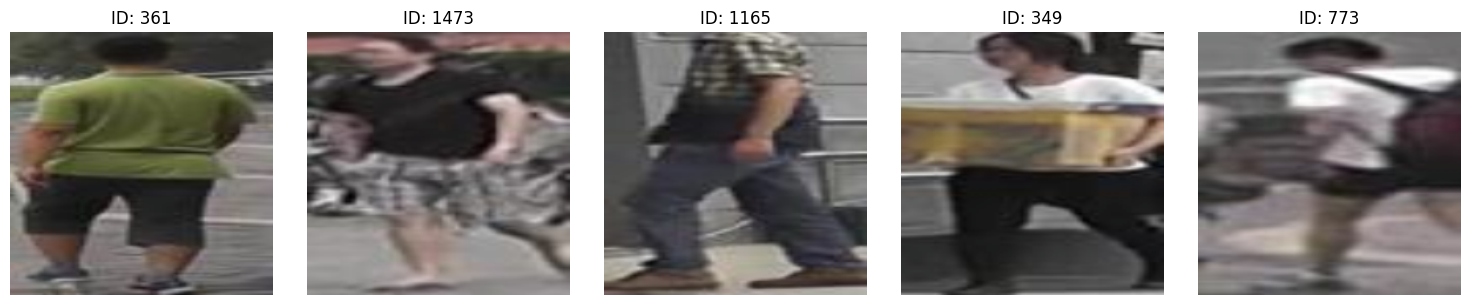

Epoch: 1/2, Batch: 10, Loss: 5.0205, Local Loss: 5.0109, Global Loss: 0.0192, Time/batch: 11.768s
Epoch 1/2 completed in 155.30s
Avg Loss: 4.9796, Avg Local Loss: 4.9690, Avg Global Loss: 0.0212
Epoch: 2/2, Batch: 10, Loss: 5.0105, Local Loss: 4.9980, Global Loss: 0.0251, Time/batch: 11.430s
Epoch 2/2 completed in 136.83s
Avg Loss: 4.9765, Avg Local Loss: 4.9636, Avg Global Loss: 0.0258
Training complete


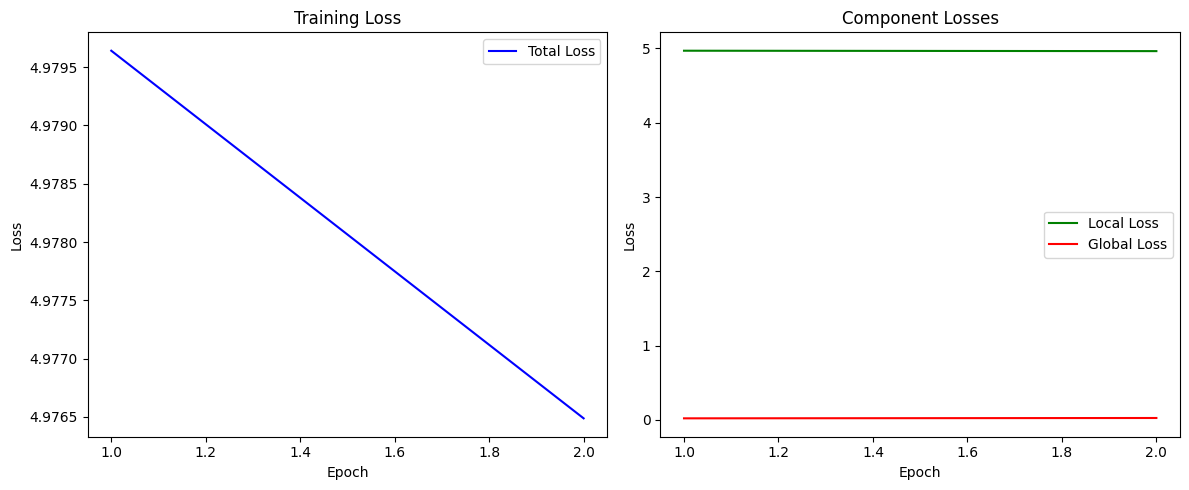

c:\Users\Aryan Pandit\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
C:\Users\Aryan Pandit\AppData\Local\Temp\ipykernel_21768\3208768369.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', len(top_labels))


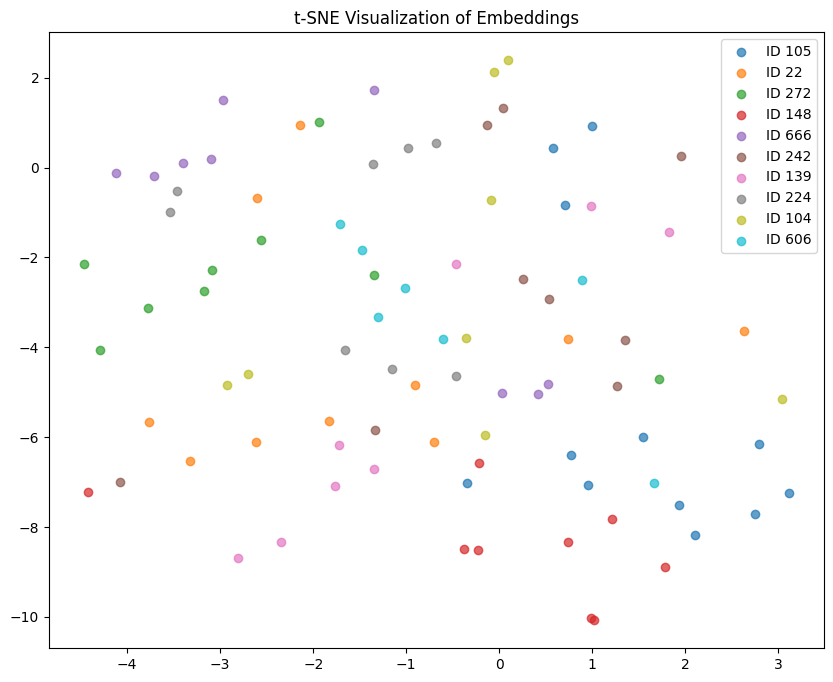

In [9]:
def visualize_embeddings(embeddings, labels, num_classes=10):
    
    if len(embeddings) > 2000:
        indices = np.random.choice(len(embeddings), 2000, replace=False)
        embeddings = embeddings[indices]
        labels = labels[indices]
    
    embeddings_np = embeddings.numpy()
    labels_np = labels.numpy()
    
    unique_labels, counts = np.unique(labels_np, return_counts=True)
    top_labels = unique_labels[np.argsort(-counts)][:num_classes]
    
    mask = np.isin(labels_np, top_labels)
    filtered_embeddings = embeddings_np[mask]
    filtered_labels = labels_np[mask]
    
    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=2, perplexity=30, n_iter=3000)
    embeddings_tsne = tsne.fit_transform(filtered_embeddings)
    
    plt.figure(figsize=(10, 8))
    
    cmap = plt.cm.get_cmap('tab10', len(top_labels))

    for i, label in enumerate(top_labels):
        idx = filtered_labels == label
        plt.scatter(embeddings_tsne[idx, 0], embeddings_tsne[idx, 1], c=[cmap(i)], label=f'ID {label}', alpha=0.7)
    
    plt.legend()
    plt.title('t-SNE Visualization of Embeddings')
    plt.savefig('embeddings_tsne.png')
    plt.show()

dataset_root = './Market-1501-v15.09.15'

if not os.path.exists(dataset_root):
    print(f"Dataset not found at {os.path.abspath(dataset_root)}")
    print("Please update 'dataset_root' variable to point to the correct Market-1501 folder")
else:
    print(f"Dataset found at {os.path.abspath(dataset_root)}")
    
    data_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    train_dataset = Market1501Dataset(dataset_root, transform=data_transforms, is_train=True)
    test_dataset = Market1501Dataset(dataset_root, transform=data_transforms, is_train=False)
    
    print(f"Training set: {len(train_dataset)} images")
    print(f"Test set: {len(test_dataset)} images")
    
    def show_sample_images(dataset, num_samples=5):
        fig, axs = plt.subplots(1, num_samples, figsize=(15, 3))
        for i in range(num_samples):
            img, label = dataset[np.random.randint(len(dataset))]
            # Denormalize image for display
            img = img.permute(1, 2, 0).numpy()
            img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img = np.clip(img, 0, 1)
            axs[i].imshow(img)
            axs[i].set_title(f"ID: {label}")
            axs[i].axis('off')
        plt.tight_layout()
        plt.show()
    
    show_sample_images(train_dataset)
    
    subset_size = 1500
    indices = torch.randperm(len(train_dataset))[:subset_size]
    subset_dataset = torch.utils.data.Subset(train_dataset, indices)
    train_loader = DataLoader(subset_dataset, batch_size=128, shuffle=True, num_workers=0)
    test_loader = DataLoader(subset_dataset, batch_size=32, shuffle=False, num_workers=0)
    
    embedding_size = 128
    model = InceptionSubnet(embedding_size=embedding_size).to(device)
    
    criterion = DeepMetricLoss(margin=0.2, lambda_param=0.5)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    num_epochs = 2


model, losses, local_losses, global_losses = train_model(model, train_loader, criterion, optimizer, device, num_epochs=num_epochs)
torch.save(model.state_dict(), 'deep_metric_model.pth')
test_embeddings, test_labels = test_model(model, test_loader, device)
visualize_embeddings(test_embeddings, test_labels)